# Pythonによる医療データ分析入門 chapter 1

### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.15.4
BuildVersion:	19E287


### Python

In [3]:
!python -V

Python 3.7.4


### Import

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Setting

In [5]:
pd.set_option('display.max_columns', None)
plt.style.use('default')

## 医療データ分析の目的

1. あるイベント（死亡・入院・手術・診断など）の発生率rを、性別や年齢などの変数で表現すること
2. 分析手法・結果に、医学的・疫学的な解釈性・妥当性を与えること

## 1. 死亡率や入院発生率のシミュレーション

- 日本の疫学に関する公的統計を利用して、死亡率や入院発生率などを算出し、乱数シミュレーションにより医療データを疑似生成する手法を説明する
- データソース：[日本版死亡データベース](http://www.ipss.go.jp/p-toukei/JMD/index.asp)


### 年齢の定義：ALBとANB

- ALB: 満年齢
- ANB: 保険年齢

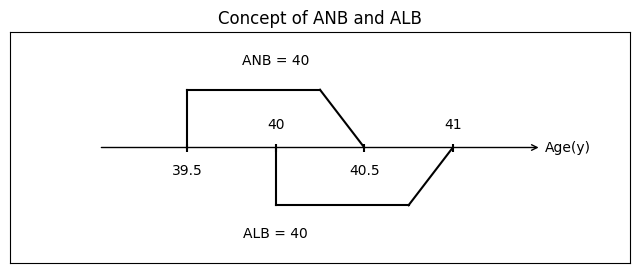

In [6]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.annotate(s = '', xytext = [39, 0], xy = [41.5, 0],
           arrowprops = dict(arrowstyle = '->', color = 'k'))
ax.text(41.65, 0, 'Age(y)', va = 'center', ha = 'center')

# ANB
ax.plot([39.5, 40.25], [0.5, 0.5], c = 'k')
ax.plot([39.5, 39.5], [0, 0.5], c = 'k')
ax.plot([40.25, 40.5], [0.5, 0], c = 'k')
ax.text(40, 0.75, 'ANB = 40', va = 'center', ha = 'center')

# ALB
ax.plot([40, 40.75], [-0.5, -0.5], c = 'k')
ax.plot([40, 40], [0, -0.5], c = 'k')
ax.plot([40.75, 41], [-0.5, 0], c = 'k')
ax.text(40, -0.75, 'ALB = 40', va = 'center', ha = 'center')

## Age
ax.text(39.5, -0.2,'39.5', va = 'center', ha = 'center')
ax.text(40, 0.2,'40', va = 'center', ha = 'center')
ax.text(40.5, -0.2,'40.5', va = 'center', ha = 'center')
ax.text(41, 0.2,'41', va = 'center', ha = 'center')
X = np.arange(4)/2 + 39.5
Y = np.zeros(4)
ax.scatter(X, Y, c = 'k', marker = '|')


ax.set_xlim(38.5, 42)
ax.set_xticklabels('')
ax.set_ylim(-1, 1)
ax.set_yticklabels('')
ax.tick_params(top = False, bottom = False, left = False)
ax.set_title('Concept of ANB and ALB');

### 出生比率

In [7]:
# delim_whitespaceを指定するとspaceとかtabをdelimiterとして扱う。

url = 'http://www.ipss.go.jp/p-toukei/JMD/00/STATS/Births.txt'
df_birth = pd.read_csv(url,skiprows = 1, delim_whitespace=True)
df_birth.head()

,Year,Female,Male,Total
0,1947,1301806,1376986,2678792
1,1948,1303060,1378564,2681624
2,1949,1316630,1380008,2696638
3,1950,1134396,1203111,2337507
4,1951,1043048,1094641,2137689


In [8]:
df_1 = df_birth.loc[:, ['Year', 'Female']].copy()
df_2 = df_birth.loc[:, ['Year', 'Male']].copy()

for i in [df_1, df_2]:
    i.columns = ['year', 'Num']
df_1['sex'] = 'F'
df_2['sex'] = 'M'

df_birth_2 = pd.concat([df_1, df_2], axis= 0, ignore_index  = True)
df_birth_2.head()

,year,Num,sex
0,1947,1301806,F
1,1948,1303060,F
2,1949,1316630,F
3,1950,1134396,F
4,1951,1043048,F


累積比率を計算する

In [9]:
df_birth_2['ratio'] = df_birth_2['Num']/df_birth_2['Num'].sum()
df_birth_2['cum_ratio'] = df_birth_2['ratio'].cumsum()
df_birth_2.head()

,year,Num,sex,ratio,cum_ratio
0,1947,1301806,F,0.012150,0.012150
1,1948,1303060,F,0.012162,0.024311
2,1949,1316630,F,0.012288,0.036600
3,1950,1134396,F,0.010587,0.047187
4,1951,1043048,F,0.009735,0.056922


### 月次死亡率

IPSSより公表されている死亡率はANBベース。つまり「ちょうどx歳になった人が、これから１年間で死亡する確率」のこと。一方、これkら作成する`df_mortality`はALBベースの月次死亡率。

x歳の月次死亡率を$q_x^m$とすると、１年間生存する確率は$(1 - q_x^m)^{12}$、よって年間死亡率は$1 - (1 - q_x^m)^{12}$.これを一次のマクローリン展開で近似すると

$$
q_x\approx 12 q^m_x
$$

In [10]:
url = 'http://www.ipss.go.jp/p-toukei/JMD/00/STATS/Mx_1x1.txt'
df_mortality = pd.read_csv(url,skiprows = 1, delim_whitespace=True, )
df_mortality.head()

,Year,Age,Female,Male,Total
0,1947,0,0.087401,0.099181,0.093432
1,1947,1,0.033723,0.034697,0.034220
2,1947,2,0.016994,0.016804,0.016897
3,1947,3,0.011412,0.011461,0.011437
4,1947,4,0.006918,0.007337,0.007130


In [11]:
df_mortality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7770 entries, 0 to 7769
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    7770 non-null   int64 
 1   Age     7770 non-null   object
 2   Female  7770 non-null   object
 3   Male    7770 non-null   object
 4   Total   7770 non-null   object
dtypes: int64(1), object(4)
memory usage: 303.6+ KB


In [12]:
df_mortality_2 = df_mortality.loc[df_mortality['Year'] == 2016, :].copy()
df_mortality_2['Age'].replace('110+', '110', inplace = True)
dict_types = {'Year': 'int16', 'Age': 'int8', 'Female': 'float64', 'Male': 'float64', 'Total':'float64'}
df_mortality_2 = df_mortality_2.astype(dict_types)
df_mortality_2 = df_mortality_2.rename(columns={"Age": "anb"})
df_mortality_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 7659 to 7769
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    111 non-null    int16  
 1   anb     111 non-null    int8   
 2   Female  111 non-null    float64
 3   Male    111 non-null    float64
 4   Total   111 non-null    float64
dtypes: float64(3), int16(1), int8(1)
memory usage: 3.8 KB


In [13]:
del df_mortality_2['Total']

ここで、医療データにおける年齢はALBなので、ALB基準の死亡率に変換する。ALBx歳のANB基準平均年齢はx + 0.5歳なので、ANB基準年齢xの死亡率を$q_x$とすると、ALB基準年齢x歳の死亡率は$(q_x + q_{x+1})/2$とみなせる。

In [14]:
df_mortality_2['Female'] = (df_mortality_2['Female']+df_mortality_2['Female'].shift(-1))/2
df_mortality_2['Male'] = (df_mortality_2['Male']+df_mortality_2['Male'].shift(-1))/2
df_mortality_2 = df_mortality_2.rename(columns={"anb": "alb"})
df_mortality_2.head()

,Year,alb,Female,Male
7659,2016,0,0.001170,0.001167
7660,2016,1,0.000244,0.000259
7661,2016,2,0.000136,0.000155
7662,2016,3,0.000092,0.000114
7663,2016,4,0.000085,0.000098


### 年齢別死亡率plot

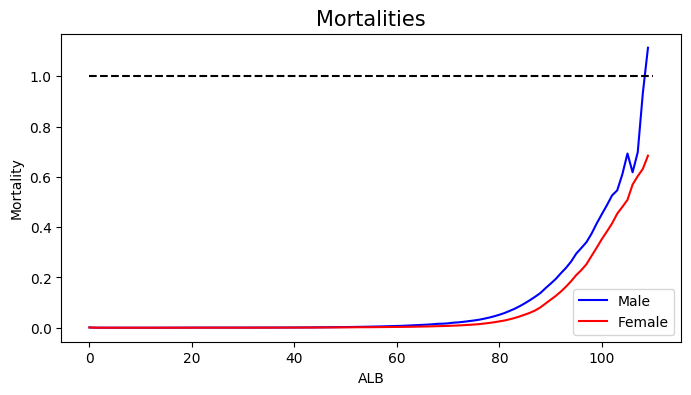

In [15]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(df_mortality_2.alb, df_mortality_2['Male'],c ='b', label = 'Male')
ax.plot(df_mortality_2.alb, df_mortality_2['Female'],c = 'r', label = 'Female')
ax.plot([0, 110], [1, 1], c = 'k', ls = '--')
ax.set_xlabel('ALB')
ax.set_ylabel('Mortality')
ax.legend(loc = 'best')
ax.set_title('Mortalities', fontsize = 15);

In [16]:
df_mortality_2 = df_mortality_2.loc[df_mortality_2['alb']<100, :].copy().reset_index(drop = True)

死亡率を年率から月率に変換する

In [17]:
df_mortality_2['F_m'] = 1 - (1 - df_mortality_2['Female'])**(1/12)
df_mortality_2['M_m'] = 1 - (1 - df_mortality_2['Male'])**(1/12)
df_mortality_2

,Year,alb,Female,Male,F_m,M_m
0,2016,0,0.001170,0.001167,0.000098,0.000097
1,2016,1,0.000244,0.000259,0.000020,0.000022
2,2016,2,0.000136,0.000155,0.000011,0.000013
3,2016,3,0.000092,0.000114,0.000008,0.000010
4,2016,4,0.000085,0.000098,0.000007,0.000008
...,...,...,...,...,...,...
95,2016,95,0.209400,0.294640,0.019390,0.028668
96,2016,96,0.229304,0.317172,0.021471,0.031293
97,2016,97,0.252797,0.340451,0.023992,0.034089
98,2016,98,0.285820,0.374441,0.027662,0.038338


## 2. 加入者情報レコードの疑似生成

In [18]:
def t_to_ym(t):
    """
    時刻t（float）を'yyyy/mm'形式の文字列に変換する
    """
    y = int(t)
    m = int((t - y)*12)+1
    m = max(min(m, 12), 1)
    return str(y) + '/' + str(m).zfill(2)

In [19]:
def ym_to_t(ym):
    y = int(ym[:4])
    m = (int(ym[5:])-0.5)/12
    return y + m

In [20]:
start_study_t = 2010   # 分析開始時点
end_study_t = 2019.999 # 分析終了時点

# 指数分布のパラメタ
mu = 10

N = 5000 # sample size
family_ratio = 0.3 # 全体のうち、被扶養者の占める割合

In [21]:
seed = 42
i = 0
np.random.seed(seed)
df_info = pd.DataFrame()
cols = ['iid', 'sex', 'family', 'birth_ym', 'start_obs_ym', 'end_obs_ym']

while len(df_info) < N:
    r = np.random.rand() # 一様乱数
    ss = df_birth_2[df_birth_2['cum_ratio'] >= r].iloc[0]
    sex = ss.sex
    by = ss.year # Birth year
    bt = by + np.random.rand()
    bym = t_to_ym(bt)
    
    start_t = start_study_t - mu + np.random.exponential(mu)
    end_t = start_t + np.random.exponential(mu)
    
    if (end_t < start_study_t ) | (end_study_t < start_t):
        pass
    else:
        df_exposure = pd.DataFrame(np.zeros(len(cols)).reshape(1, -1), columns = cols)
        family = 2 - (np.random.rand() > family_ratio)
        df_exposure[cols] = ['i' + str(i).zfill(6), sex, family, bym, t_to_ym(start_t), t_to_ym(end_t)]
        
        df_info = pd.concat([df_info, df_exposure], axis  = 0)
        i += 1
df_info = df_info.reset_index(drop = True)
df_info.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym
0,i000000,F,2.0,1994/12,2013/03,2022/04
1,i000001,M,2.0,1950/06,2003/06,2012/11
2,i000002,F,2.0,1981/05,2006/02,2021/06
3,i000003,M,1.0,1983/04,2001/01,2012/07
4,i000004,F,2.0,1960/06,2000/05,2024/05


疑似生成された加入者情報における誕生年の比率が、真の比率に従っていることを図で確認

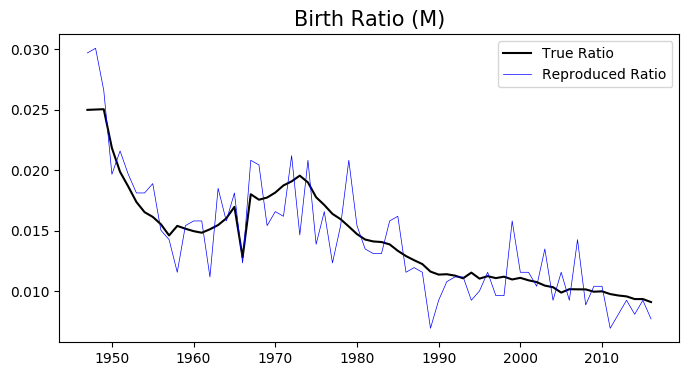

In [22]:
df_birth_M = df_birth_2.loc[df_birth_2.sex == 'M', ['year', 'ratio']]
df_birth_M['ratio'] = df_birth_M.ratio/df_birth_M.ratio.sum()

df_info_M = df_info.loc[df_info.sex == 'M', ['birth_ym', 'family']]
df_info_M['birth_ym'] = df_info.birth_ym.apply(ym_to_t)//1
df_info_M = df_info_M.groupby(['birth_ym']).count()
df_info_M = df_info_M/df_info_M.sum()

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(df_birth_M.year, df_birth_M.ratio, c = 'k', label = 'True Ratio')
ax.plot(df_info_M.index, df_info_M.family, c = 'b', label = 'Reproduced Ratio', lw = 0.5)
ax.legend(loc = 'best')
ax.set_title('Birth Ratio (M)', fontsize = 15);